In [20]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
# Load and explore data
df = pd.read_csv("../data/raw/traffic_volume_2021_plus.csv")

# Quick look
df.head()

# Basic info
df.info()

# Check for nulls
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273710 entries, 0 to 273709
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   requestid  273710 non-null  int64 
 1   boro       273710 non-null  object
 2   yr         273710 non-null  int64 
 3   m          273710 non-null  int64 
 4   d          273710 non-null  int64 
 5   hh         273710 non-null  int64 
 6   mm         273710 non-null  int64 
 7   vol        273710 non-null  int64 
 8   segmentid  273710 non-null  int64 
 9   wktgeom    273710 non-null  object
 10  street     273710 non-null  object
 11  fromst     273710 non-null  object
 12  tost       273710 non-null  object
 13  direction  273710 non-null  object
dtypes: int64(8), object(6)
memory usage: 29.2+ MB


requestid    0
boro         0
yr           0
m            0
d            0
hh           0
mm           0
vol          0
segmentid    0
wktgeom      0
street       0
fromst       0
tost         0
direction    0
dtype: int64

In [22]:
# Feature Engineering

df.rename(columns={'yr': 'year', 'm': 'month', 'd': 'day', 'hh': 'hour', 'mm': 'minute'}, inplace=True)

# Create timestamp
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Add derived time features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek  # 0=Mon, 6=Sun
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

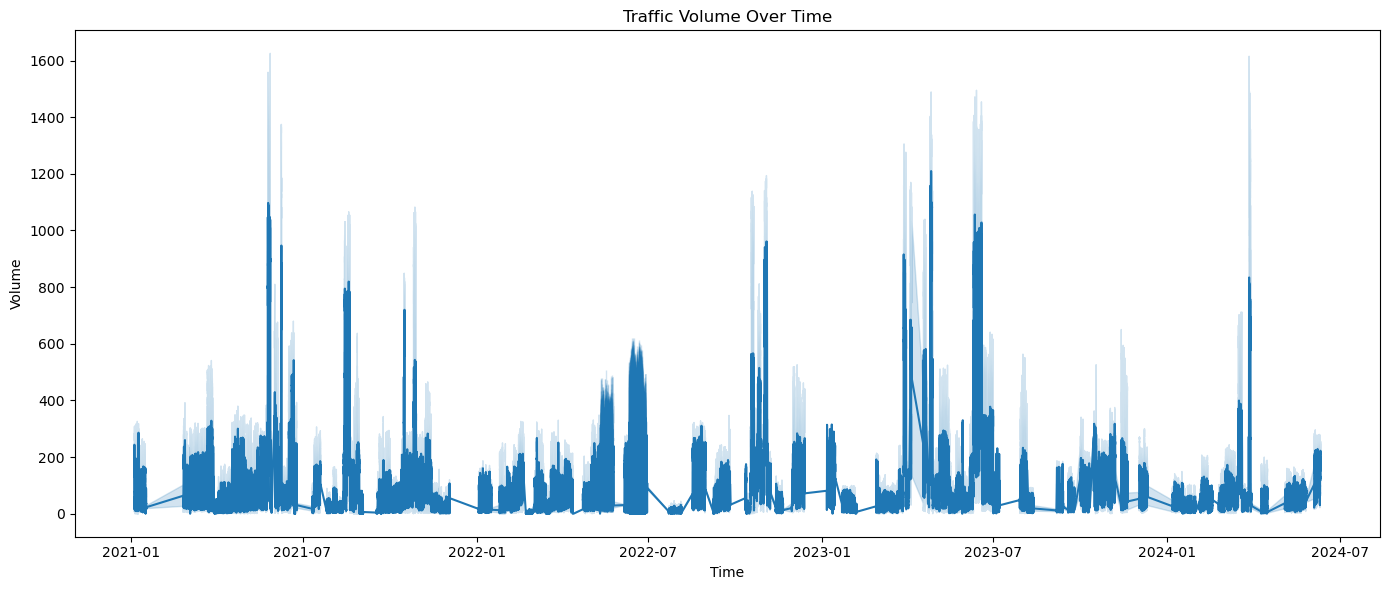

In [23]:
# Line Plot: Volume Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='timestamp', y='vol')
plt.title("Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()


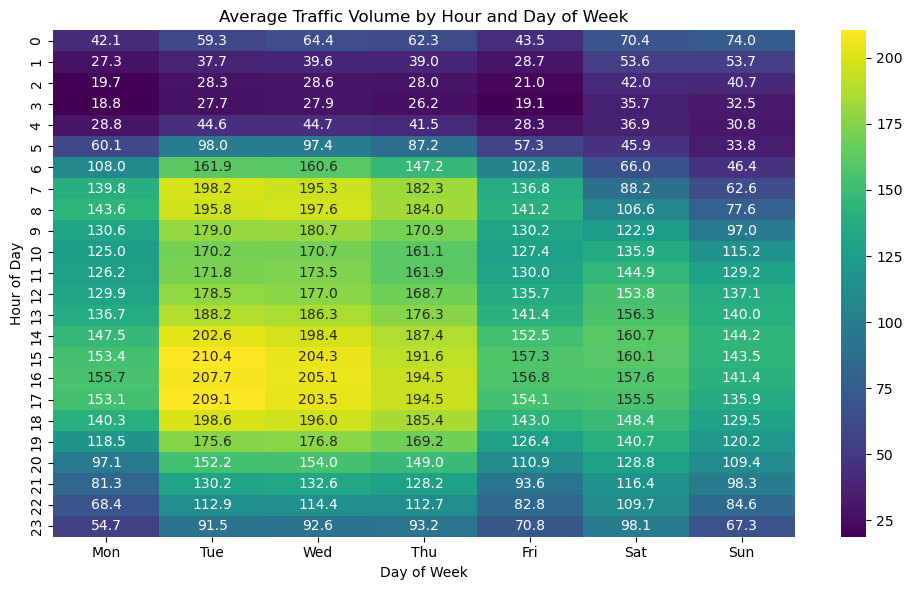

In [24]:
# Heatmap: Hour vs Day of Week

# Pivot table: rows=hour, columns=dayofweek, values=mean volume
pivot = df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')

# Rename columns from 0–6 to weekday names
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

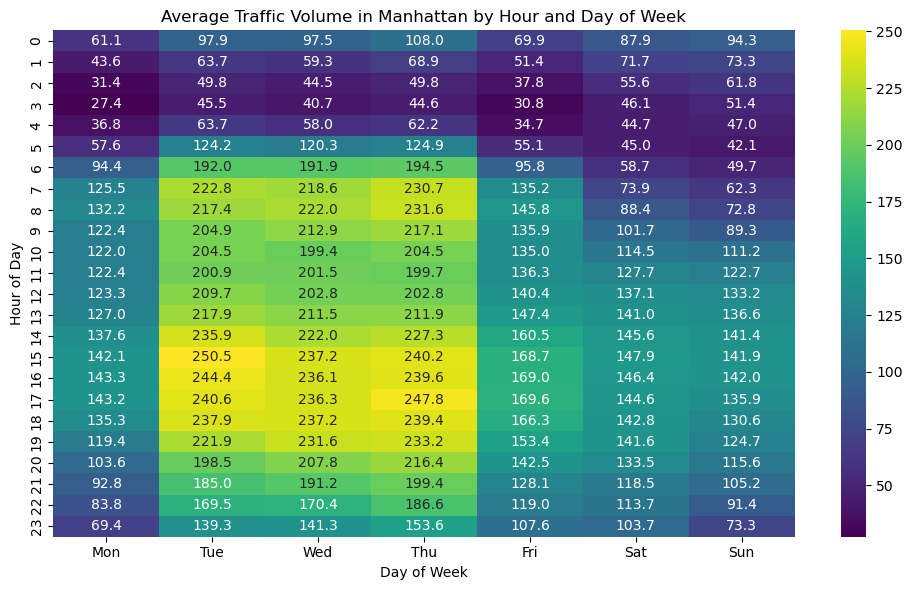

In [25]:
# Heatmap by bourough (ex. Manhattan)
manhattan_df = df[df['boro'] == 'Manhattan']

# Then pivot just like before
pivot = manhattan_df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume in Manhattan by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


In [28]:
# Train a simple model
features = ['hour', 'dayofweek', 'is_rush_hour', 'is_weekend']
X = df[features]
y = df['vol']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

description = df['vol'].describe()
print(description)

print("MAE:", mean_absolute_error(y_test, y_pred))


count    273710.000000
mean        118.384096
std         180.857653
min           0.000000
25%          23.000000
50%          62.000000
75%         137.000000
max        1829.000000
Name: vol, dtype: float64
MAE: 95.93286615931834


In [ ]:
# Log transformed model to cut down on inaccuracy

# Step 1: Define features and apply log transformation to target
features = ['hour', 'dayofweek', 'is_rush_hour', 'is_weekend']
X = df[features]

# Apply log1p to handle zeroes safely: log1p(x) = log(1 + x)
df['log_vol'] = np.log1p(df['vol'])
y = df['log_vol']

# Step 2: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict on test set
log_y_pred = model.predict(X_test)

# Step 5: Reverse log transformation
y_pred = np.expm1(log_y_pred)  # This undoes log1p
y_true = np.expm1(y_test)      # Undo transform on true labels as well

# Step 6: Evaluate
mae = mean_absolute_error(y_true, y_pred)
print("MAE after log transform:", mae)

# Visualize actual vs predicted
plt.figure(figsize=(7, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Actual vs. Predicted Volume (After Log Transform)")
plt.grid(True)
plt.show()